In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

import os 
from keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
train = pd.read_csv("data/7C_train.csv", sep="\t")
valid = pd.read_csv("data/7C_valid.csv", sep="\t")

y_train = train["Compartment Prediction"]
y_valid = valid["Compartment Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'valid sequences')

2660 train sequences
666 valid sequences


In [4]:
max_len = 1500

In [5]:
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [9]:
# NB: DO NOT USE SET, IT CHANGES ORDER OF CATEGORY EVERYTIME I RUN THE NOTEBOOK!!!!
#cat = list(set(y_train))
cat = ['ER',
 'Golgi',
 'Mitochondrion',
 'Endosome',
 'Large Protein Complex',
 'Plasma membrane',
 'Lysosome']

In [10]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [11]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [12]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [13]:
# Function to convert sequences to array of indices. I will use that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [14]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [15]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (2660, 1500)
x_valid shape: (666, 1500)


In [16]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [17]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

## Model 1

In [18]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 48
# Convolution
filters = 20
pool_size = 2

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_layer', trainable=True, mask_zero=False)(_input)

drop = Dropout(0.2)(embedded)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model1_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 2660 samples, validate on 666 samples
Epoch 1/60
2660/2660 [==============================] - 248s 93ms/step - loss: 1.4826 - accuracy: 0.5120 - val_loss: 1.4928 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.49283, saving model to models/model1_weights.hdf5
Epoch 2/60
2660/2660 [==============================] - 209s 78ms/step - loss: 1.3886 - accuracy: 0.5222 - val_loss: 1.4908 - val_accuracy: 0.5015

Epoch 00002: val_loss improved from 1.49283 to 1.49077, saving model to models/model1_weights.hdf5
Epoch 3/60
2660/2660 [==============================] - 207s 78ms/step - loss: 1.3296 - accuracy: 0.5447 - val_loss: 1.2780 - val_accuracy: 0.5601

Epoch 00003: val_loss improved from 1.49077 to 1.27803, saving model to models/model1_weights.hdf5
Epoch 4/60
2660/2660 [==============================] - 206s 77ms/step - loss: 1.2447 - accuracy: 0.5797 - val_loss: 1.2303 - val_accuracy: 0.5856

Epoch 00004: val_los


Epoch 00036: val_loss did not improve from 0.86572
Epoch 37/60
2660/2660 [==============================] - 205s 77ms/step - loss: 0.7715 - accuracy: 0.7669 - val_loss: 0.8592 - val_accuracy: 0.7372

Epoch 00037: val_loss improved from 0.86572 to 0.85917, saving model to models/model1_weights.hdf5
Epoch 38/60
2660/2660 [==============================] - 207s 78ms/step - loss: 0.7716 - accuracy: 0.7635 - val_loss: 0.8626 - val_accuracy: 0.7342

Epoch 00038: val_loss did not improve from 0.85917
Epoch 39/60
2660/2660 [==============================] - 205s 77ms/step - loss: 0.7580 - accuracy: 0.7662 - val_loss: 0.8802 - val_accuracy: 0.7372

Epoch 00039: val_loss did not improve from 0.85917
Epoch 40/60
2660/2660 [==============================] - 205s 77ms/step - loss: 0.7523 - accuracy: 0.7673 - val_loss: 0.8614 - val_accuracy: 0.7402

Epoch 00040: val_loss did not improve from 0.85917
Epoch 41/60
2660/2660 [==============================] - 210s 79ms/step - loss: 0.7366 - accuracy: 0

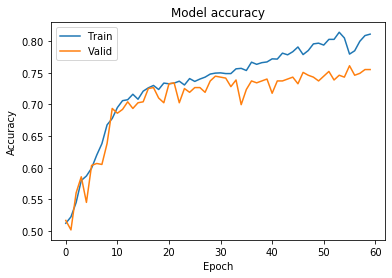

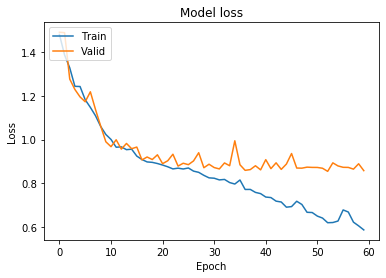

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [21]:
model = load_model('models/model1_weights.hdf5')
model.evaluate(x_valid_pad, y_valid_OH, verbose=0)

[0.8545500505435932, 0.7387387156486511]

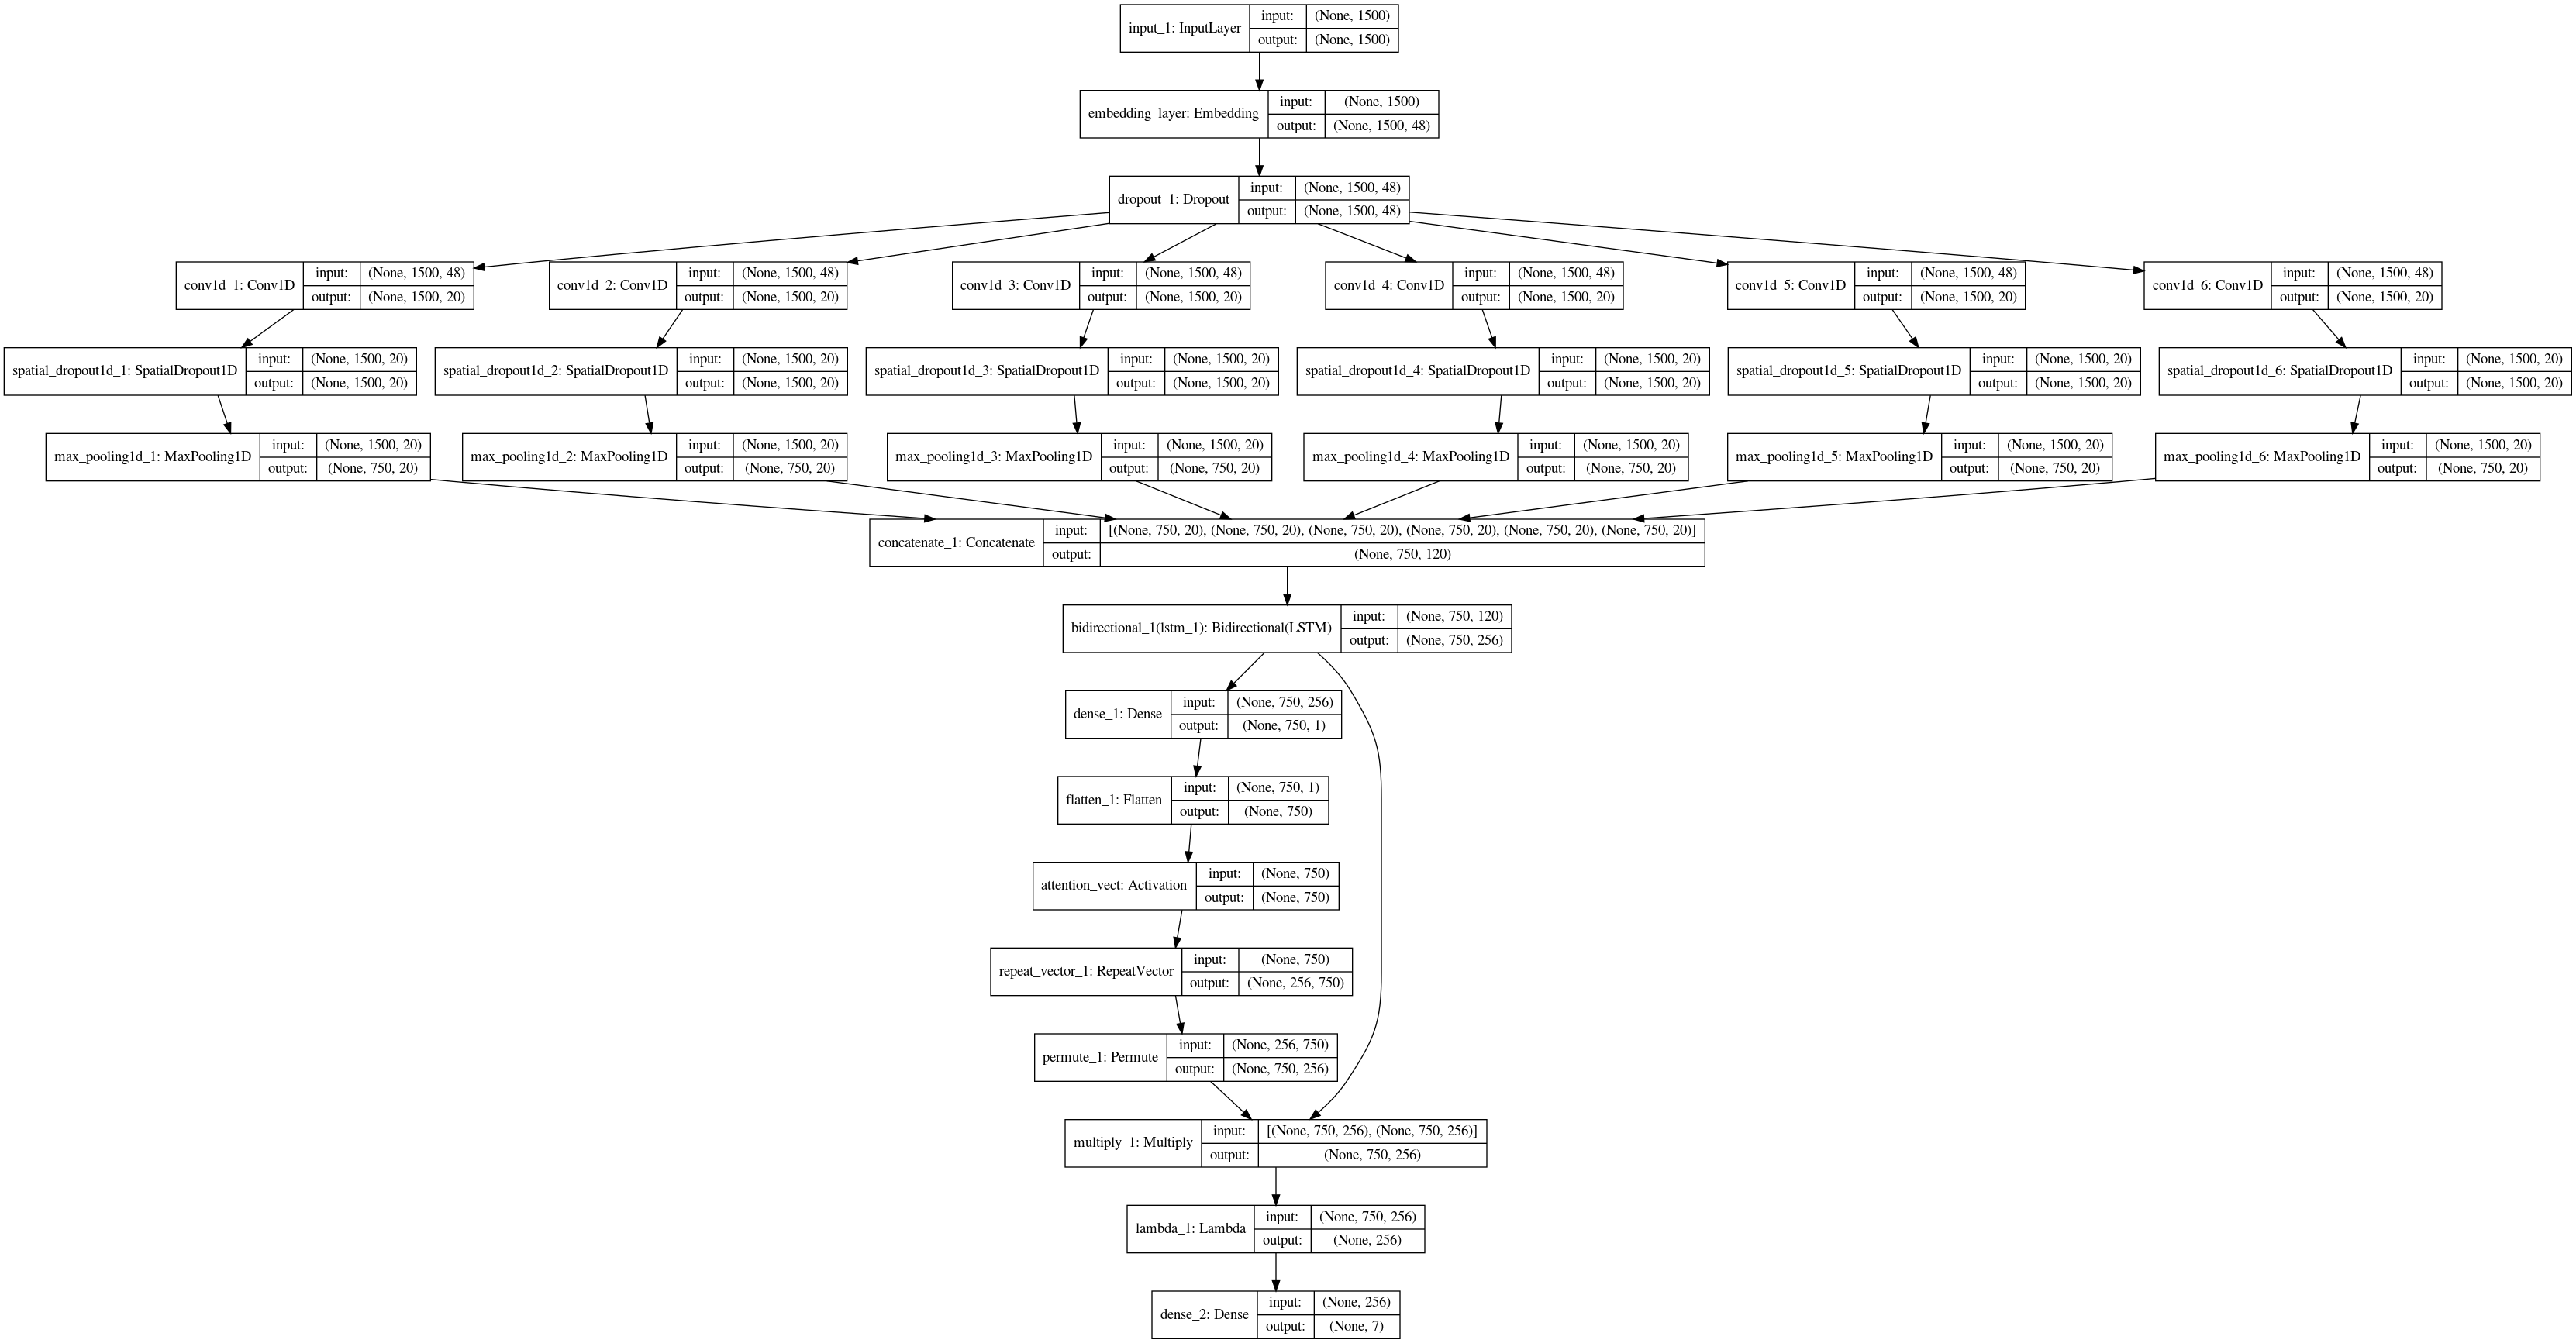

In [22]:
plot_model(model, to_file='models/model1_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
y_pred = model.predict(x_valid_pad)
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

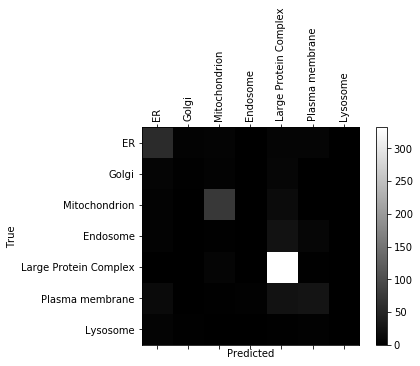

In [24]:
def confusion_plot(y_valid, y_pred_label, cat):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
confusion_plot(y_valid, y_pred_label, cat)

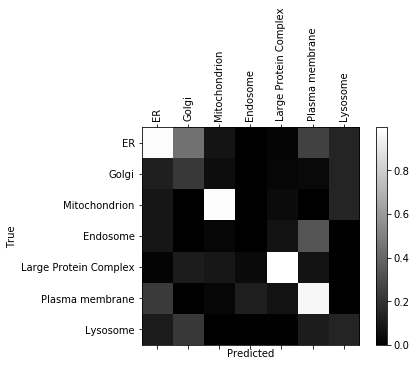

In [25]:
def confusion_plot_norm(y_valid, y_pred_label, cat, axis=1):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx / (conf_mx.max(axis=axis)+1), cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return(conf_mx)
conf = confusion_plot_norm(y_valid, y_pred_label, cat, axis=1)

In [26]:
conf

array([[ 56,   4,   6,   0,   7,   7,   1],
       [  7,   2,   4,   0,   8,   1,   1],
       [  5,   0,  75,   0,  15,   0,   1],
       [  5,   0,   2,   0,  24,   9,   0],
       [  1,   1,   7,   1, 332,   2,   0],
       [ 13,   0,   2,   3,  24,  26,   0],
       [  6,   2,   0,   0,   2,   3,   1]])

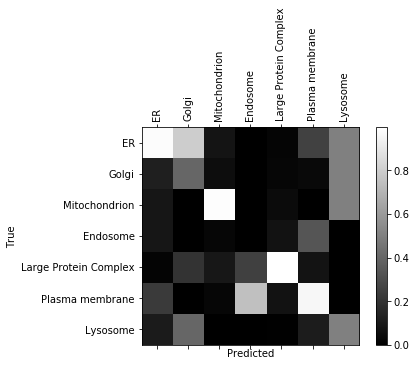

In [27]:
conf = confusion_plot_norm(y_valid, y_pred_label, cat, axis=0)

In [28]:
print(classification_report(y_valid, y_pred_label))

                       precision    recall  f1-score   support

                   ER       0.60      0.69      0.64        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.22      0.09      0.12        23
Large Protein Complex       0.81      0.97      0.88       344
             Lysosome       0.25      0.07      0.11        14
        Mitochondrion       0.78      0.78      0.78        96
      Plasma membrane       0.54      0.38      0.45        68

             accuracy                           0.74       666
            macro avg       0.46      0.43      0.43       666
         weighted avg       0.67      0.74      0.70       666



# Model 2
Several layer LSTM plus attention 

In [68]:
max_features = tot_aa
embedding_size = 40
units = 96

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(
        input_dim=max_features,
        output_dim=embedding_size,
        input_length=max_len,
        name = 'embedding_layer',
        trainable=True,
        mask_zero=False
    )(_input)

lstm1 = Bidirectional(LSTM(128, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(embedded)
lstm2 = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(lstm1)

# compute importance for each step
attention = Dense(1, activation='tanh')(lstm2)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([lstm2, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

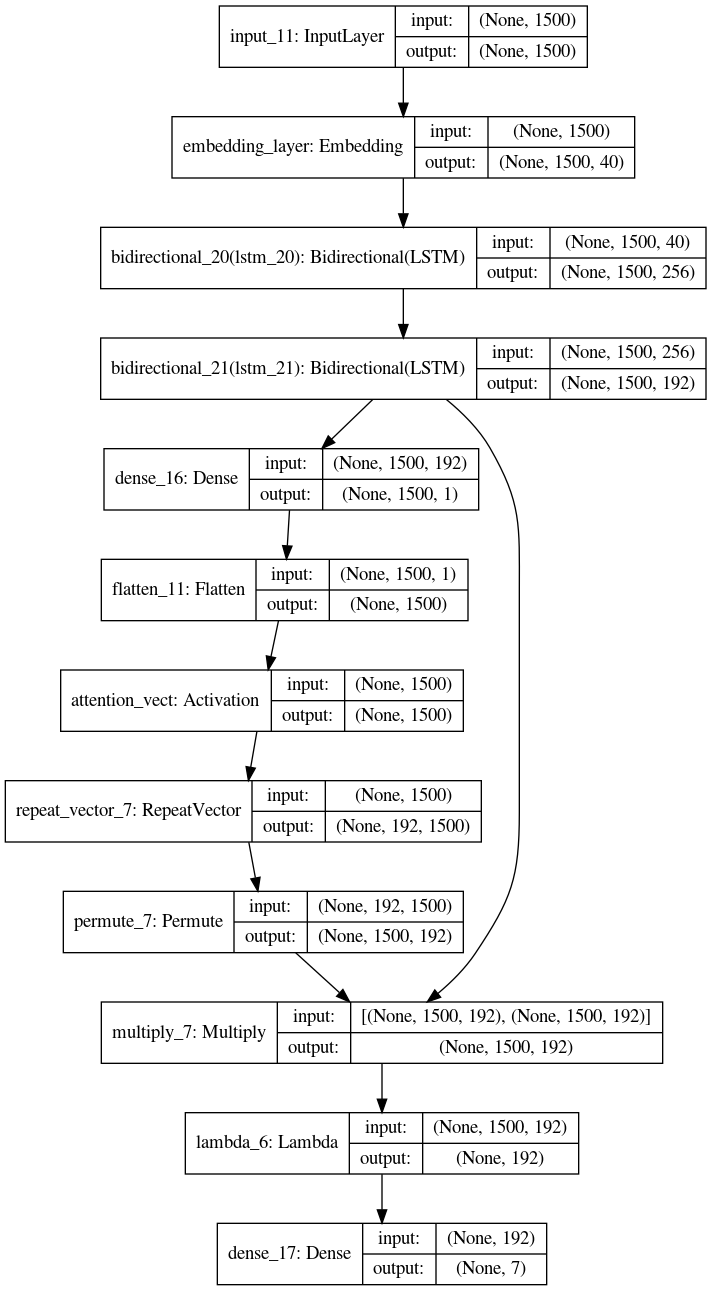

In [69]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/model2_plot.png', show_shapes=True, show_layer_names=True)

In [70]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model2_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/50
2660/2660 [==============================] - 628s 236ms/step - loss: 1.5005 - accuracy: 0.5086 - val_loss: 1.5077 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.50775, saving model to models/model2_weights.hdf5
Epoch 2/50
2660/2660 [==============================] - 563s 212ms/step - loss: 1.4449 - accuracy: 0.5184 - val_loss: 1.4954 - val_accuracy: 0.4775

Epoch 00002: val_loss improved from 1.50775 to 1.49537, saving model to models/model2_weights.hdf5
Epoch 3/50
2660/2660 [==============================] - 553s 208ms/step - loss: 1.4452 - accuracy: 0.5071 - val_loss: 1.4090 - val_accuracy: 0.5045

Epoch 00003: val_loss improved from 1.49537 to 1.40897, saving model to models/model2_weights.hdf5
Epoch 4/50
2660/2660 [==============================] - 549s 206ms/step - loss: 1.4013 - accuracy: 0.5139 - val_loss: 1.3835 - val_accuracy: 0.5375

Epoch 00004: val_loss improved from 1.40897 to 1.38354, saving m

2660/2660 [==============================] - 612s 230ms/step - loss: 0.8919 - accuracy: 0.7331 - val_loss: 0.9053 - val_accuracy: 0.7297

Epoch 00038: val_loss did not improve from 0.88383
Epoch 39/50
2660/2660 [==============================] - 559s 210ms/step - loss: 0.8707 - accuracy: 0.7338 - val_loss: 0.9242 - val_accuracy: 0.7117

Epoch 00039: val_loss did not improve from 0.88383
Epoch 40/50
2660/2660 [==============================] - 613s 230ms/step - loss: 0.9076 - accuracy: 0.7252 - val_loss: 0.9336 - val_accuracy: 0.7252

Epoch 00040: val_loss did not improve from 0.88383
Epoch 41/50
2660/2660 [==============================] - 734s 276ms/step - loss: 0.8866 - accuracy: 0.7316 - val_loss: 0.8896 - val_accuracy: 0.7342

Epoch 00041: val_loss did not improve from 0.88383
Epoch 42/50
2660/2660 [==============================] - 691s 260ms/step - loss: 0.8633 - accuracy: 0.7350 - val_loss: 0.8954 - val_accuracy: 0.7372

Epoch 00042: val_loss did not improve from 0.88383
Epoch 4

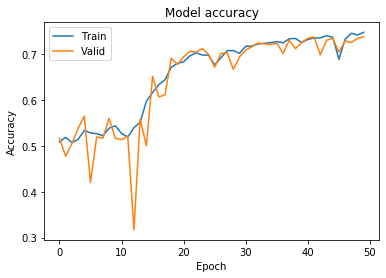

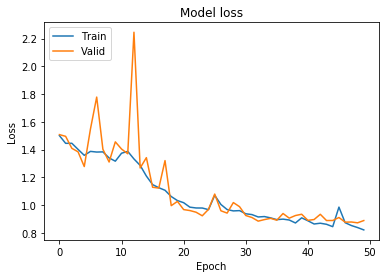

In [71]:
def history_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
history_plot(history)

In [72]:
model2 = load_model('models/model2_weights.hdf5')
model2.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 43s 64ms/step


[0.8717243356389685, 0.7342342138290405]

In [73]:
y_pred2 = model2.predict(x_valid_pad)
y_pred2_indices = OH_to_label_indices(y_pred2)
y_pred2_label = indices_to_cat(y_pred2_indices)

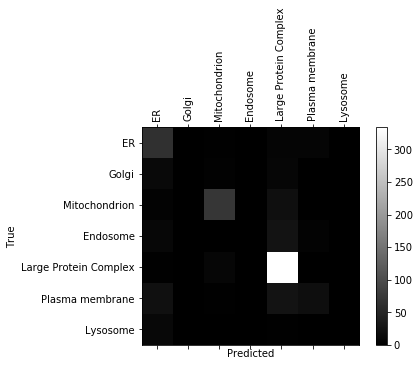

In [74]:
confusion_plot(y_valid, y_pred2_label, cat)

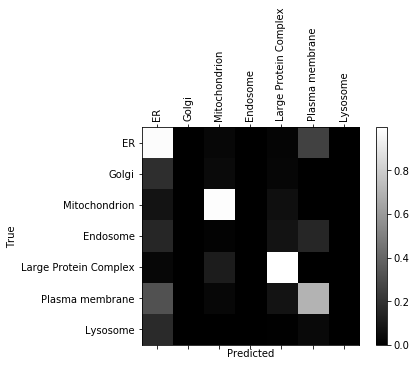

array([[ 65,   0,   2,   0,   7,   7,   0],
       [ 12,   0,   3,   0,   8,   0,   0],
       [  5,   0,  71,   0,  20,   0,   0],
       [ 10,   0,   1,   0,  25,   4,   0],
       [  2,   0,   8,   0, 334,   0,   0],
       [ 21,   0,   2,   0,  26,  19,   0],
       [ 11,   0,   0,   0,   2,   1,   0]])

In [75]:
confusion_plot_norm(y_valid, y_pred2_label, cat, axis=1)

In [76]:
print(classification_report(y_valid, y_pred2_label))

                       precision    recall  f1-score   support

                   ER       0.52      0.80      0.63        81
             Endosome       0.00      0.00      0.00        40
                Golgi       0.00      0.00      0.00        23
Large Protein Complex       0.79      0.97      0.87       344
             Lysosome       0.00      0.00      0.00        14
        Mitochondrion       0.82      0.74      0.78        96
      Plasma membrane       0.61      0.28      0.38        68

             accuracy                           0.73       666
            macro avg       0.39      0.40      0.38       666
         weighted avg       0.65      0.73      0.68       666



/home/julie/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 3
3 LSTM layers, I so don't believe in this

In [81]:
max_features = tot_aa
embedding_size = 40
units = 128

_input = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded = Embedding(
        input_dim=max_features,
        output_dim=embedding_size,
        input_length=max_len,
        name = 'embedding_layer',
        trainable=True,
        mask_zero=False
    )(_input)

lstm1 = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(embedded)
lstm2 = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(lstm1)
lstm3 = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(lstm2)

# compute importance for each step
attention = Dense(1, activation='tanh')(lstm3)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([lstm3, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

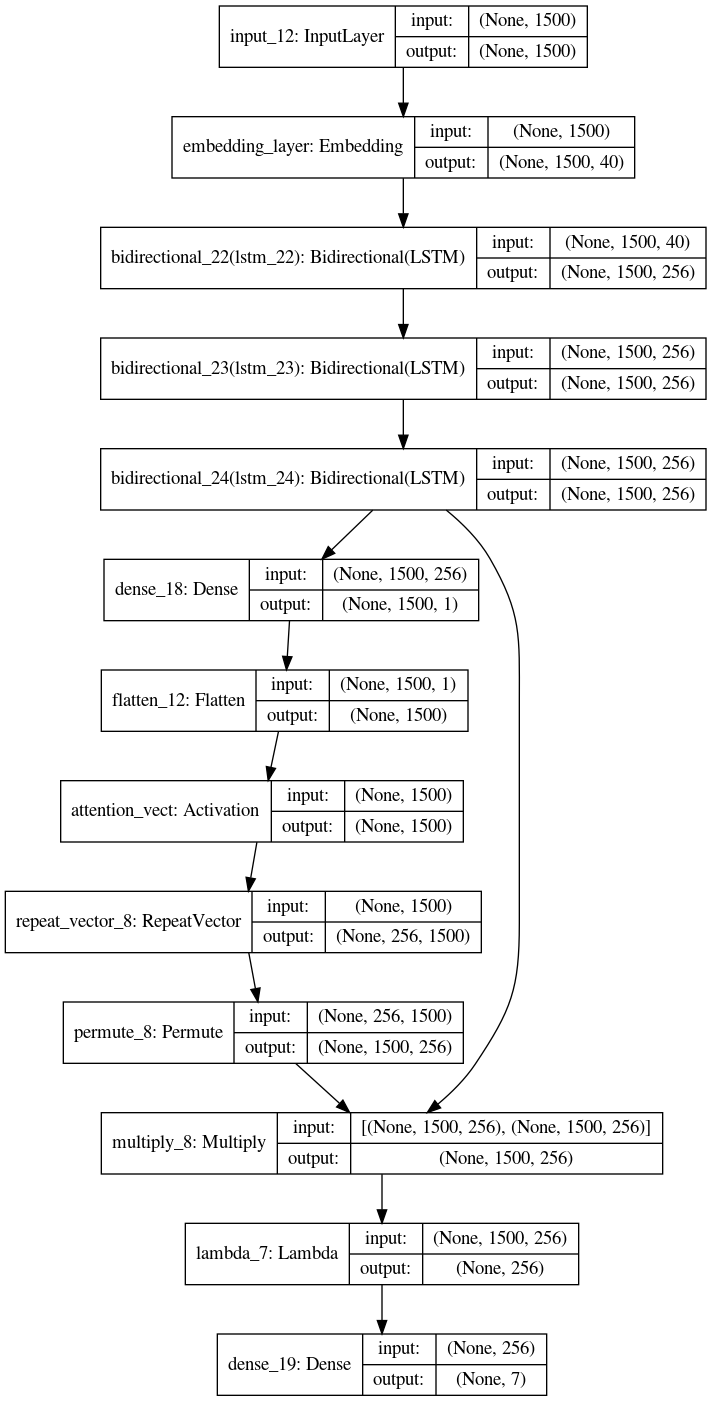

In [82]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model = Model(inputs=_input, outputs=probabilities)
plot_model(model, to_file='models/model3_plot.png', show_shapes=True, show_layer_names=True)

In [83]:
model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model3_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history3 = model.fit(x_train_pad, y_train_OH, 
                    batch_size=32, epochs=50,
                    class_weight = class_weights,
          validation_data=[x_valid_pad, y_valid_OH], callbacks=[ckpt])

Train on 2660 samples, validate on 666 samples
Epoch 1/50
2660/2660 [==============================] - 1109s 417ms/step - loss: 1.5296 - accuracy: 0.5071 - val_loss: 1.6034 - val_accuracy: 0.5165

Epoch 00001: val_loss improved from inf to 1.60336, saving model to models/model3_weights.hdf5
Epoch 2/50
2660/2660 [==============================] - 1072s 403ms/step - loss: 1.5085 - accuracy: 0.5041 - val_loss: 1.6420 - val_accuracy: 0.2718

Epoch 00002: val_loss did not improve from 1.60336
Epoch 3/50
2660/2660 [==============================] - 1049s 394ms/step - loss: 1.4705 - accuracy: 0.5135 - val_loss: 1.4541 - val_accuracy: 0.5165

Epoch 00003: val_loss improved from 1.60336 to 1.45405, saving model to models/model3_weights.hdf5
Epoch 4/50
2660/2660 [==============================] - 1046s 393ms/step - loss: 1.4617 - accuracy: 0.5150 - val_loss: 1.6543 - val_accuracy: 0.5165

Epoch 00004: val_loss did not improve from 1.45405
Epoch 5/50
2660/2660 [==============================] - 1


Epoch 00039: val_loss did not improve from 1.31751
Epoch 40/50
2660/2660 [==============================] - 1107s 416ms/step - loss: 1.4060 - accuracy: 0.5271 - val_loss: 1.4109 - val_accuracy: 0.5150

Epoch 00040: val_loss did not improve from 1.31751
Epoch 41/50
2660/2660 [==============================] - 1065s 400ms/step - loss: 1.3579 - accuracy: 0.5357 - val_loss: 1.2937 - val_accuracy: 0.5661

Epoch 00041: val_loss improved from 1.31751 to 1.29368, saving model to models/model3_weights.hdf5
Epoch 42/50
2660/2660 [==============================] - 1059s 398ms/step - loss: 1.3076 - accuracy: 0.5586 - val_loss: 1.2915 - val_accuracy: 0.5736

Epoch 00042: val_loss improved from 1.29368 to 1.29154, saving model to models/model3_weights.hdf5
Epoch 43/50
2660/2660 [==============================] - 1157s 435ms/step - loss: 1.2666 - accuracy: 0.5812 - val_loss: 1.1996 - val_accuracy: 0.6021

Epoch 00043: val_loss improved from 1.29154 to 1.19959, saving model to models/model3_weights.h

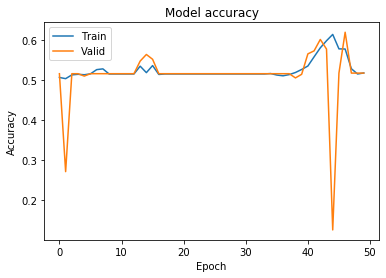

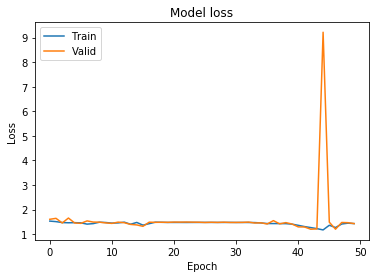

In [84]:
history_plot(history3)
# That's so shit 

In [85]:
model2 = load_model('models/model3_weights.hdf5')
model2.evaluate(x_valid_pad, y_valid_OH)

666/666 [==============================] - 102s 153ms/step


[1.1995940691715963, 0.6021021008491516]

## Embedding Analysis

In [77]:
embedding = model.get_layer('embedding_layer').get_weights()
embedding = embedding[0]
embedding.shape

(22, 40)

In [78]:
embedding2 = model2.get_layer('embedding_layer').get_weights()
embedding2 = embedding2[0]
embedding2.shape

(22, 40)

In [30]:
def plot_embedding(embedding, aa):
    fig, ax = plt.subplots()
    plt.scatter(embedding[:, 0], embedding[:, 1], edgecolor='none')
    aaL = list(aa)
    for i in range(len(aaL)):
        ax.annotate(aaL[i], (embedding[:, 0][i], embedding[:, 1][i]))
    
    plt.show()

### PCA plot

original shape:    (22, 48)
transformed shape: (22, 2)


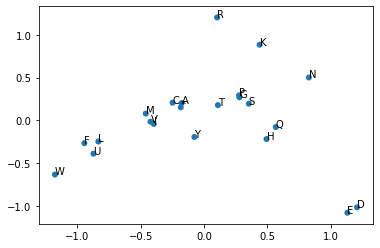

In [31]:
# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)
plot_embedding(embedding_pca, aa)

### t-SNE plot

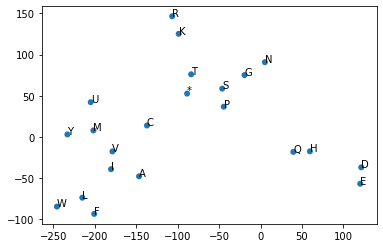

In [32]:
# tSNE plots of Embedding 
tSNE = TSNE(n_components=2, perplexity=3)
embedding_tSNE = tSNE.fit_transform(embedding)
plot_embedding(embedding_tSNE, aa)

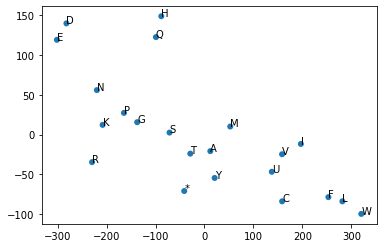

In [80]:
tSNE = TSNE(n_components=2, perplexity=3)
embedding2_tSNE = tSNE.fit_transform(embedding2)
plot_embedding(embedding2_tSNE, aa)

### UMAP plot

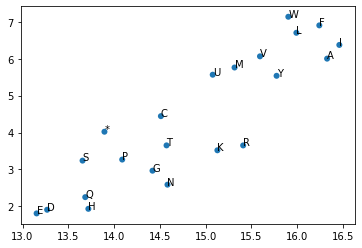

In [36]:
# umap plots of Embedding 
Umap = umap.UMAP(n_components=2, n_neighbors= 4)
embedding_Umap = Umap.fit_transform(embedding)
plot_embedding(embedding_Umap, aa)

## Attention Layer Analysis

In [37]:
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_vect').output])
outputs = model.predict(x_valid_pad)
model_outputs = outputs[0]
attention_outputs = outputs[1]

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

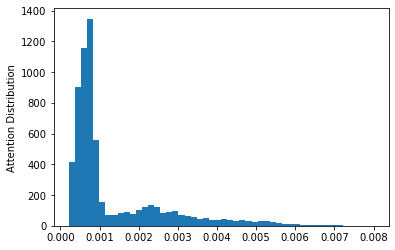

In [38]:
attention_distrib = np.concatenate( attention_outputs, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution')

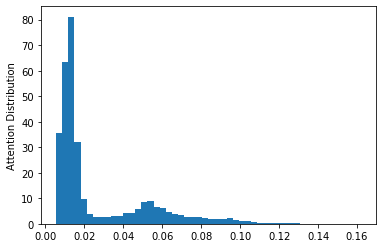

In [39]:
# Normalize attention values 
norm_attention = []
for seq in attention_outputs:
    norm_attention.append(seq / np.linalg.norm(seq))
    
attention_distrib = np.concatenate( norm_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

### Attention visualization for a single sequence

Because I pooled (pool size = 2) attention is len = 750. 
So I need to duplicate every values.

In [112]:
def indices_to_seq(X):
    seq = ''
    for i in range(len(X)):
        seq +=int_to_aa[X[i]] 
    return seq

In [113]:
# pool_size = 2
Attention_1500 = []
A = []
for x in norm_attention:
    for i in range(len(x)):
        A.append(x[i])
        A.append(x[i])
    Attention_1500.append(np.array(A))
    A = []

In [114]:
# I don't fully understand that code
# the color_charvals function doesn't work that well because my vector is big
# and the values are very small, I need a better function

class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def color_charvals(s):
    r = 0
    if s.val < 0.07:
        r = 255
    elif s.val > 0.1:
        r = 0
    else:
        r = 255*(1 - (s.val-0.07)/0.03)
    r = int(r)
    color = rgb_to_hex((255, r, 255))
    return 'background-color: %s' % color
    
    #r = int(255/(s.val*10 +1))
    #color = rgb_to_hex((r, r, r))
    #return 'background-color: %s' % color

In [115]:
# Number of highest values to select
nb_max = 30
max_att_indexes = []
for seq in Attention_1500:
    max_att_indexes.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))
max_att_nopad = []    
for x in range(len(x_valid)):
    max_att_nopad.append(max_att_indexes[x]-(1500-len(x_valid[x])))

In [116]:
X = 3

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_nopad[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236
0,M,L,E,E,D,M,E,V,A,I,K,M,V,V,V,G,N,G,A,V,G,K,S,S,M,I,Q,R,Y,C,K,G,I,F,T,K,D,Y,K,K,T,I,G,V,D,F,L,E,R,Q,I,Q,V,N,D,E,D,V,R,L,M,L,W,D,T,A,G,Q,E,E,F,D,A,I,T,K,A,Y,Y,R,G,A,Q,A,C,V,L,V,F,S,T,T,D,R,E,S,F,E,A,V,S,S,W,R,E,K,V,V,A,E,V,G,D,I,P,T,V,L,V,Q,N,K,I,D,L,L,D,D,S,C,I,K,N,E,E,A,E,A,L,A,K,R,L,K,L,R,F,Y,R,T,S,V,K,E,D,L,N,V,N,E,V,F,K,Y,L,A,E,K,Y,L,Q,K,L,K,Q,Q,I,A,E,D,P,E,L,T,H,S,S,S,N,K,I,G,V,F,N,T,S,G,G,S,H,S,G,Q,N,S,G,T,L,N,G,G,D,V,I,N,L,R,P,N,K,Q,R,T,K,K,N,R,N,P,F,S,S,C,S,I,P


## Error Analysis

In [117]:
# Add the prediction to Valid dataframe
valid["Model Prediction"] = y_pred_label

In [118]:
valid.groupby(["Compartment Prediction", "Model Prediction"]).count()#/len(valid)*100

Lead Protein ID  \
Compartment Prediction Model Prediction                         
ER                     ER                                  52   
                       Large Protein Complex                2   
                       Mitochondrion                        3   
                       Plasma membrane                     15   
Endosome               ER                                   3   
                       Large Protein Complex               17   
                       Plasma membrane                     11   
Golgi                  ER                                   8   
                       Golgi                                3   
                       Large Protein Complex                4   
                       Mitochondrion                        2   
Large Protein Complex  ER                                   5   
                       Large Protein Complex              295   
                       Mitochondrion                        2   
                       Plasma membrane                      6   
Lysosome               ER                                   4   
                       Golgi                                1   
                       Lysosome                             2   
                       Plasma membrane                      5   
Mitochondrion          ER                                   3   
                       Golgi                                1   
                       Large Protein Complex               15   
                       Mitochondrion                       64   
                       Plasma membrane                      5   
Plasma membrane        ER                                   5   
                       Large Protein Complex               23   
                       Plasma membrane                     31   

                                              Prediction Confidence  Sequence  \
Compartment Prediction Model Prediction                                         
ER                     ER                                        52        52   
                       Large Protein Complex                      2         2   
                       Mitochondrion                              3         3   
                       Plasma membrane                           15        15   
Endosome               ER                                         3         3   
                       Large Protein Complex                     17        17   
                       Plasma membrane                           11        11   
Golgi                  ER                                         8         8   
                       Golgi                                      3         3   
                       Large Protein Complex                      4         4   
                       Mitochondrion                              2         2   
Large Protein Complex  ER                                         5         5   
                       Large Protein Complex                    295       295   
                       Mitochondrion                              2         2   
                       Plasma membrane                            6         6   
Lysosome               ER                                         4         4   
                       Golgi                                      1         1   
                       Lysosome                                   2         2   
                       Plasma membrane                            5         5   
Mitochondrion          ER                                         3         3   
                       Golgi                                      1         1   
                       Large Protein Complex                     15        15   
                       Mitochondrion                             64        64   
                       Plasma membrane                            5         5   
Plasma membrane        ER                             

In [119]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred_indices[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [120]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 447 correctly classified exemples
There is 140 incorrectly classified exemples
So the accuracy is: 76.14991482112437


In [121]:
corrects_df = valid[valid.index.isin(corrects)]
corrects_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
2,Q9BQ61,Large Protein Complex,Very High,MAARGRRAEPQGREAPGPAGGGGGGSRWAESGSGTSPESGDEEVSG...,176,Large Protein Complex
5,P35606,Large Protein Complex,High,MPLRLDIKRKLTARSDRVKSVDLHPTEPWMLASLYNGSVCVWNHET...,906,Large Protein Complex
6,O95168,Mitochondrion,Medium,MSFPKYKPSSLRTLPETLDPAEYNISPETRRAQAERLAIRAQLKRE...,129,Mitochondrion
7,Q2TAA5,ER,Medium,MAAGERSWCLCKLLRFFYSLFFPGLIVCGTLCVCLVIVLWGIRLLL...,492,ER
9,Q96G23,ER,Very High,MLQTLYDYFWWERLWLPVNLTWADLEDRDGRVYAKASDLYITLPLA...,380,ER


In [122]:
# Now I use these list of indices to split the valid pandas dataframe
falses_df = valid[valid.index.isin(falses)]
falses_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,Model Prediction
0,Q4KMP7,Plasma membrane,Very High,METGTAPLVAPPRRHGAPAAPSPPPRGSRAGPVVVVAPGPPVTTAT...,808,Large Protein Complex
1,O95159,Golgi,High,MGLCKCPKRKVTNLFCFEHRVNVCEHCLVANHAKCIVQSYLQWLQD...,310,ER
3,Q9ULC3,Plasma membrane,Very High,MLEEDMEVAIKMVVVGNGAVGKSSMIQRYCKGIFTKDYKKTIGVDF...,237,Large Protein Complex
4,Q16774,Mitochondrion,Medium,MSGPRPVVLSGPSGAGKSTLLKRLLQEHSGIFGFSVSHTTRNPRPG...,197,Large Protein Complex
8,Q96AQ8,Mitochondrion,High,MDCGSVGGQRTQRLPGRQRLLFLPVGLSGRPGGSETSARRCLSALS...,359,Plasma membrane


### Checking how low/very low Prediction Confidence proteins are classified

And to a certain extend, low confidence proteins are more often wrongly classified.
It make sense but it is not as bad as I was expecting.

It could make sense to remove these exemples from the dataset altogether. 

In [123]:
falses_df["Prediction Confidence"].value_counts()/ len(falses_df)*100

Very High    37.142857
High         35.714286
Medium       27.142857
Name: Prediction Confidence, dtype: float64

In [124]:
corrects_df["Prediction Confidence"].value_counts()/ len(corrects_df)*100

Very High    42.95302
High         35.57047
Medium       21.47651
Name: Prediction Confidence, dtype: float64

## Checking model on test set 

In [125]:
test = pd.read_csv("data/7C_test.csv", sep="\t")
y_test = test["Compartment Prediction"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

In [126]:
model = load_model('models/model1_weights.hdf5')
score = model.evaluate(x_test_pad, y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

734/734 [==============================] - 17s 23ms/step
Test loss: 0.8050011456499957
Test accuracy: 0.7588555812835693


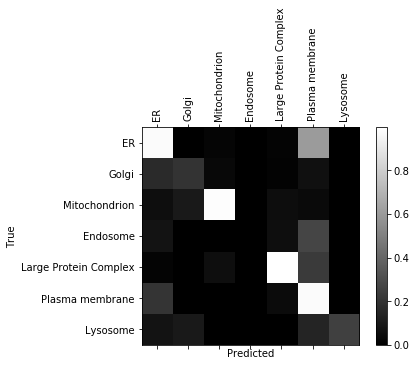

In [127]:
y_pred_test = model.predict(x_test_pad)
y_pred_indices_test = OH_to_label_indices(y_pred_test)
y_pred_label_test = indices_to_cat(y_pred_indices_test)

conf_mx = confusion_matrix(y_test, y_pred_label_test, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=1)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()